# 무역 데이터 EDA (HS4 / item_id 단위 EDA 및 micro-level deep dive)

**코드 셀 동작 설명**

- **주요 범주**: 라이브러리 임포트, 데이터 로드, 시각화(Seaborn), 수치/데이터프레임 처리
- 데이터 파일을 읽어 DataFrame으로 로드
- 그래프/차트로 결과 시각화

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_train = pd.read_csv('train.csv')
print(df_train.head(20))



     item_id  year  month  seq  type   hs4      weight  quantity       value
0   DEWLVASR  2022      1  1.0     1  3038     14858.0       0.0     32688.0
1   ELQGMQWE  2022      1  1.0     1  2002     62195.0       0.0    110617.0
2   AHMDUILJ  2022      1  1.0     1  2102     18426.0       0.0     72766.0
3   XIPPENFQ  2022      1  1.0     1  2501     20426.0       0.0     11172.0
4   FTSVTTSR  2022      1  1.0     1  2529    248000.0       0.0    143004.0
5   XMKRPGLB  2022      1  1.0     1  2529    558000.0       0.0    205676.0
6   RCBZUSIM  2022      1  1.0     1  2805         0.0       0.0       459.0
7   SUOYXCHP  2022      1  1.0     1  2805         0.0       0.0       482.0
8   ZKENOUDA  2022      1  1.0     1  2805         2.0       0.0      2783.0
9   WQMVCOEM  2022      1  1.0     1  2805       187.0       0.0    217777.0
10  BSRMSVTC  2022      1  1.0     1  2805       111.0       0.0     33952.0
11  DDEXPPXU  2022      1  1.0     1  2807       387.0       0.0     13158.0

Zero & Missing Flag 생성 코드
개요

value, weight, quantity 세 변수에 대해

Zero flag: 값이 0인지 표시

Missing flag: 값이 NaN인지 표시
를 생성해 데이터 품질 이슈를 모델이 인식하도록 만든다.

In [19]:
# Zero flag 생성
df_train['value_zero'] = (df_train['value'] == 0).astype(int)
df_train['weight_zero'] = (df_train['weight'] == 0).astype(int)
df_train['quantity_zero'] = (df_train['quantity'] == 0).astype(int)

# Missing flag 생성
df_train['value_missing'] = df_train['value'].isna().astype(int)
df_train['weight_missing'] = df_train['weight'].isna().astype(int)
df_train['quantity_missing'] = df_train['quantity'].isna().astype(int)

## HS2 코드 매핑 설명

딕셔너리는 HS2 코드(01~97)를 해당 품목군의 한국어 이름으로 연결한 매핑이다.

key는 2자리 문자열 형태의 HS2 코드이며, value는 해당 코드를 의미하는 품목군 명칭이다.

총 97개의 HS2 챕터가 모두 포함되어 있어 hs4 앞 두 자리를 기반으로 품목군 이름을 조회할 수 있다.

In [20]:
hs2_map = {
    "01": "산동물",
    "02": "육과 식용설육",
    "03": "어패류",
    "04": "낙농품·조란·천연동물성 식품",
    "05": "기타 동물성 생산품",
    "06": "산수목·꽃",
    "07": "채소",
    "08": "과실·견과류",
    "09": "커피·향신료",

    "10": "곡물",
    "11": "밀가루·전분",
    "12": "채유용 종자·인삼",
    "13": "식물성 엑스",
    "14": "기타 식물성 생산품",
    "15": "동식물성 유지",
    "16": "육·어류 조제품",
    "17": "당류·설탕과자",
    "18": "코코아·초콜릿",
    "19": "곡물·곡분 주제품·빵류",

    "20": "채소·과실의 조제품",
    "21": "기타 조제식료품",
    "22": "음료·주류·식초",
    "23": "조제사료",
    "24": "담배",
    "25": "토석류·소금",
    "26": "광·슬랙·회",
    "27": "광물성 연료·에너지",
    "28": "무기화합물",
    "29": "유기화합물",

    "30": "의료용품",
    "31": "비료",
    "32": "염료·안료·페인트·잉크",
    "33": "향료·화장품",
    "34": "비누·계면활성제·왁스",
    "35": "카세인·알부민·변성전분·효소",
    "36": "화약류·성냥",
    "37": "필름·인화지·사진용 재료",
    "38": "기타 화학공업 품목",
    "39": "플라스틱과 그 제품",

    "40": "고무와 그 제품",
    "41": "원피·가죽",
    "42": "가죽제품",
    "43": "모피·모피제품",
    "44": "목재·목탄",
    "45": "코르크·코르크 제품",
    "46": "조물재료 제품",
    "47": "펄프",
    "48": "지·판지",
    "49": "서적·신문·인쇄물",

    "50": "견·견사·견직물",
    "51": "양모·수모",
    "52": "면·면사·면직물",
    "53": "마류사·직물",
    "54": "인조 필라멘트 섬유",
    "55": "인조 스테이플 섬유",
    "56": "워딩·부직포",
    "57": "양탄자",
    "58": "특수 직물",
    "59": "침투·도포 직물",

    "60": "편물",
    "61": "의류(편물제)",
    "62": "의류(편물제 외)",
    "63": "기타 섬유제품·넝마",
    "64": "신발류",
    "65": "모자류",
    "66": "우산·지팡이",
    "67": "조제 우모·인조제품",
    "68": "석·시멘트·석면 제품",
    "69": "도자 제품",

    "70": "유리",
    "71": "귀석·반귀석·귀금속",
    "72": "철강",
    "73": "철강제품",
    "74": "동과 그 제품",
    "75": "니켈과 그 제품",
    "76": "알루미늄과 그 제품",
    "78": "연과 그 제품",
    "79": "아연과 그 제품",

    "80": "주석과 그 제품",
    "81": "기타 비금속",
    "82": "비금속 공구·스푼·포크",
    "83": "각종 비금속 제품",
    "84": "보일러·기계류",
    "85": "전기기기·TV·VTR",
    "86": "철도차량",
    "87": "일반차량",
    "88": "항공기",
    "89": "선박",

    "90": "광학·의료·측정·정밀기기",
    "91": "시계",
    "92": "악기",
    "93": "무기",
    "94": "가구·조명기구",
    "95": "완구·운동용품",
    "96": "잡품",
    "97": "예술품·골동품"
}


## 전처리·월별 집계·패널(panel) 구성 코드 설명

- year, month 컬럼을 정수형으로 변환해 날짜 연산이 가능하도록 정리한다.

- hs4 컬럼은 문자열로 통일하여 품목 코드를 안정적으로 다룰 수 있게 한다.

- value, weight, quantity는 숫자형으로 강제 변환해 계산 오류를 방지한다.

- year + month 기준으로 date 컬럼을 생성해 월 단위 시계열을 만든다.

- item_id + hs4 + date 묶음으로 월별 거래 데이터를 합산하여 중복 거래를 제거한다.

- 전체 기간(min~max month)과 전체 item_id 목록을 이용해 item_id × month의 모든 조합을 생성한다.

- 실제 월별 집계 데이터와 merge하여 누락된 월도 포함된 완전한 패널 데이터를 구성한다.

- 기존에 거래가 없어서 비어 있는 월은 is_missing_month 플래그로 표시한다.

- date에서 다시 year, month를 복원해 분석/모델 입력 형식을 편하게 만든다.

- 마지막에 (item_id, date) 조합이 중복되지 않았는지 검증해 패널 구조의 정상성을 확인한다.

In [21]:
import pandas as pd

# 타입 정리: hs4 문자열, year/month 정수, date datetime, 수치 컬럼 numeric
# year/month 정수화
if "year" in df_train.columns:
    df_train["year"] = pd.to_numeric(df_train["year"], errors="coerce").astype("Int64")
if "month" in df_train.columns:
    df_train["month"] = pd.to_numeric(df_train["month"], errors="coerce").astype("Int64")

# hs4는 문자열(누락은 <NA> 유지)
if "hs4" in df_train.columns:
    try:
        df_train["hs4"] = df_train["hs4"].astype("Int64").astype("string")
    except Exception:
        df_train["hs4"] = df_train["hs4"].astype("string")

# 수치 컬럼 강제 numeric
agg_cols = ["value", "weight", "quantity"]
for c in agg_cols:
    if c in df_train.columns:
        df_train[c] = pd.to_numeric(df_train[c], errors="coerce")

# ------------------------------------
# 0) date 컬럼 만들기 (year, month 기준)
# ------------------------------------
# year, month가 있고 date가 아직 없을 때만 생성
if "date" not in df_train.columns:
    df_train["date"] = pd.to_datetime(
        df_train["year"].astype(int).astype(str) + "-" +
        df_train["month"].astype(int).astype(str) + "-01"
    )

# 혹시 date가 object/string인 경우 datetime으로 변환
df_train["date"] = pd.to_datetime(df_train["date"])

# ------------------------------------
# 1) 월별 집계 (중복거래 제거 핵심)
#    item_id + hs4 + date 기준으로 value/weight/quantity 합산
# ------------------------------------
agg_cols = ["value", "weight", "quantity"]

df_train_monthly = (
    df_train
    .groupby(["item_id", "hs4", "date"], as_index=False)[agg_cols]
    .sum()
)

print("월별 집계 결과 예시:")
print(df_train_monthly.head())

# ------------------------------------
# 2) 전체 month 범위 & item_id 목록 만들기
# ------------------------------------
min_month = df_train_monthly["date"].min()
max_month = df_train_monthly["date"].max()

full_months = pd.date_range(min_month, max_month, freq="MS")
all_items = df_train_monthly["item_id"].unique()

# ------------------------------------
# 3) item_id × date 전체 조합 (풀 패널 인덱스)
# ------------------------------------
panel = pd.MultiIndex.from_product(
    [all_items, full_months],
    names=["item_id", "date"]
).to_frame(index=False)

# ------------------------------------
# 4) 집계된 df_train_monthly와 merge해서 패널 완성
# ------------------------------------
df_panel = (
    panel.merge(df_train_monthly, on=["item_id", "date"], how="left")
         .sort_values(["item_id", "date"])
         .reset_index(drop=True)
)

# hs4를 문자열 dtype으로 일관 유지 (결측은 <NA>)
if "hs4" in df_panel.columns:
    try:
        df_panel["hs4"] = df_panel["hs4"].astype("Int64").astype("string")
    except Exception:
        df_panel["hs4"] = df_panel["hs4"].astype("string")

# 거래 없던 month 식별 플래그: 모든 수치가 NaN이면 결측 월로 간주
df_panel['is_missing_month'] = df_panel[agg_cols].isna().all(axis=1)

# 연/월 컬럼 다시 생성 및 downcast
df_panel["year"] = df_panel["date"].dt.year.astype("Int16")
df_panel["month"] = df_panel["date"].dt.month.astype("Int8")

# 수치 컬럼 downcast로 메모리 최적화
downcast_float_cols = [col for col in ['value', 'weight', 'quantity'] if col in df_panel.columns]
for col in downcast_float_cols:
    df_panel[col] = df_panel[col].astype('float32')

df_panel['is_missing_month'] = df_panel['is_missing_month'].astype(bool)

print("최종 패널 예시:")
print(df_panel.head())

# 중복 체크 (item_id, date 조합이 유일한지)
dup_cnt = df_panel.duplicated(["item_id", "date"]).sum()
if dup_cnt > 0:
    print(f"⚠️ (item_id, date) 중복 row {dup_cnt}개 발견")
    dup_preview = df_panel[df_panel.duplicated(["item_id", "date"], keep=False)].head()
    print("중복 예시:")
    print(dup_preview)
else:
    print("중복 row 개수: 0 (정상)")


월별 집계 결과 예시:
    item_id   hs4       date    value    weight  quantity
0  AANGBULD  4810 2022-01-01  14276.0   17625.0       0.0
1  AANGBULD  4810 2022-02-01  52347.0   67983.0       0.0
2  AANGBULD  4810 2022-03-01  53549.0   69544.0       0.0
3  AANGBULD  4810 2022-05-01  26997.0   34173.0       0.0
4  AANGBULD  4810 2022-06-01  84489.0  103666.0       0.0
최종 패널 예시:
    item_id       date   hs4    value   weight  quantity  is_missing_month  \
0  AANGBULD 2022-01-01  4810  14276.0  17625.0       0.0             False   
1  AANGBULD 2022-02-01  4810  52347.0  67983.0       0.0             False   
2  AANGBULD 2022-03-01  4810  53549.0  69544.0       0.0             False   
3  AANGBULD 2022-04-01  <NA>      NaN      NaN       NaN              True   
4  AANGBULD 2022-05-01  4810  26997.0  34173.0       0.0             False   

   year  month  
0  2022      1  
1  2022      2  
2  2022      3  
3  2022      4  
4  2022      5  
중복 row 개수: 0 (정상)


- hs4 코드를 정리해 앞 두 자리만 추출한 HS2 대분류 코드를 생성한다.

- 생성된 HS2 코드에 한국어 품목군 이름을 매핑해 사람이 읽을 수 있는 카테고리 정보로 확장한다.

In [22]:
df_panel["hs2"] = df_panel["hs4"].astype("string").str[:2]
df_panel["hs2_name_kr"] = df_panel["hs2"].map(hs2_map)

- df_panel.isnull().sum()
전체 컬럼에서 결측치가 몇 개 있는지 요약해 보는 점검 코드다.

- df_panel.duplicated().sum()
완전 동일한 행(row)이 반복되는지 체크해 데이터 중복 문제를 탐지한다.

- df_panel.head()
패널 데이터가 기대한 형태로 생성됐는지 첫 몇 줄을 확인하는 기본 점검용 출력이다.

In [23]:
print(df_panel.isnull().sum())
print('--------------------------')
print(df_panel.duplicated().sum())
print('--------------------------')
print(df_panel.head())


item_id               0
date                  0
hs4                 524
value               524
weight              524
quantity            524
is_missing_month      0
year                  0
month                 0
hs2                 524
hs2_name_kr         524
dtype: int64
--------------------------
0
--------------------------
    item_id       date   hs4    value   weight  quantity  is_missing_month  \
0  AANGBULD 2022-01-01  4810  14276.0  17625.0       0.0             False   
1  AANGBULD 2022-02-01  4810  52347.0  67983.0       0.0             False   
2  AANGBULD 2022-03-01  4810  53549.0  69544.0       0.0             False   
3  AANGBULD 2022-04-01  <NA>      NaN      NaN       NaN              True   
4  AANGBULD 2022-05-01  4810  26997.0  34173.0       0.0             False   

   year  month   hs2 hs2_name_kr  
0  2022      1    48        지·판지  
1  2022      2    48        지·판지  
2  2022      3    48        지·판지  
3  2022      4  <NA>         NaN  
4  2022      5    48   

HS2 결측값 보정 및 한글명 매핑 설명
1. HS4에서 HS2 코드 추출

hs4 값의 앞 두 자리를 사용해 HS2(대분류) 코드를 만든다.

문자열 변환을 통해 코드 자릿수와 형식을 안정적으로 유지한다.

2. HS2 결측값 보정

HS2 코드가 비어 있거나 생성되지 않은 경우 "UN" 같은 미지정 코드로 대체해 결측 상태를 명확히 표시한다.

3. HS2 한글 품목군 명칭 매핑

HS2 코드를 hs2_map에 매핑하여 한국어 품목군 이름을 부여한다.

매핑되지 못한 값(예: "UN")은 "미지정"으로 표기해 분류되지 않은 항목을 구분한다.

In [24]:
# HS2 결측값 보정 및 한글명 매핑 (fallback 포함)
df_panel["hs2"] = df_panel["hs4"].astype("string").str[:2]
df_panel["hs2"] = df_panel["hs2"].fillna("UN")

df_panel["hs2_name_kr"] = df_panel["hs2"].map(hs2_map).fillna("미지정")


거래량·결측·Zero 플래그 패널 전처리 설명
1. 거래량 기본 컬럼 정의

value, weight, quantity 세 가지 거래량 관련 핵심 수치 컬럼을 하나의 리스트로 묶어 이후 반복 계산을 단순화한다.

2. 월 단위 결측 상태 플래그 생성

세 거래량 컬럼이 모두 NaN이면 해당 월에 거래가 전혀 없었던 것으로 판단한다.

이를 is_missing_month 플래그로 기록해, 실제 결측 월을 명확하게 구분한다.

플래그가 이미 존재한다면 다시 생성하지 않아 중복을 방지한다.

3. Zero 플래그 재계산

거래량 값이 정확히 0인지 여부를 다시 계산하여
value_zero, weight_zero, quantity_zero 플래그로 기록한다.

패널 생성 과정에서 새로운 0 값이 생길 수 있기 때문에
전체 패널 기준으로 일관되게 다시 계산하는 단계이다.

4. Missing 플래그 재계산

수치 컬럼이 NaN인지 여부를 다시 계산해
value_missing, weight_missing, quantity_missing 플래그에 반영한다.

패널 생성 후 NaN이 추가될 수 있기 때문에,
정확한 결측 상태를 다시 확정하는 과정이다.

5. 패널 상태 점검

전처리 후 생성된 패널 데이터를 일부 확인하여
플래그가 정상적으로 적용되었는지 검증한다.

In [25]:
# 거래량 관련 수치 컬럼
value_cols = ['value', 'weight', 'quantity']

# NaN 유지 정책: 없는 월은 NaN으로 보존하고 플래그로만 표기
if 'is_missing_month' not in df_panel.columns:
    df_panel['is_missing_month'] = df_panel[value_cols].isna().all(axis=1)

missing_mask = df_panel['is_missing_month']

# 패널 기준으로 zero/missing 플래그를 일관되게 재계산
for col, flag in zip(value_cols, ['value_zero', 'weight_zero', 'quantity_zero']):
    df_panel[flag] = ((df_panel[col].fillna(np.nan) == 0).astype(int))
    df_panel.loc[missing_mask, flag] = 0  # 결측 월은 zero 플래그 0으로 고정

for col, flag in zip(value_cols, ['value_missing', 'weight_missing', 'quantity_missing']):
    df_panel[flag] = df_panel[col].isna().astype(int)
    df_panel.loc[missing_mask, flag] = 1  # 결측 월은 missing 플래그 1

# sanity check: zero와 missing이 동시에 1인 경우가 있는지 확인
conflict_cols = ['value', 'weight', 'quantity']
for col in conflict_cols:
    zero_flag = f"{col}_zero"
    miss_flag = f"{col}_missing"
    conflict_cnt = ((df_panel[zero_flag] == 1) & (df_panel[miss_flag] == 1)).sum()
    if conflict_cnt > 0:
        print(f"⚠️ {col} zero & missing 동시 1인 행 {conflict_cnt}개 존재")

df_panel.head()
#df_panel[df_panel['item_id'] == 'GKQIJYDH']

,item_id,date,hs4,value,weight,quantity,is_missing_month,year,month,hs2,hs2_name_kr,value_zero,weight_zero,quantity_zero,value_missing,weight_missing,quantity_missing
0,AANGBULD,2022-01-01,4810,14276.0,17625.0,0.0,False,2022,1,48,지·판지,0,0,1,0,0,0
1,AANGBULD,2022-02-01,4810,52347.0,67983.0,0.0,False,2022,2,48,지·판지,0,0,1,0,0,0
2,AANGBULD,2022-03-01,4810,53549.0,69544.0,0.0,False,2022,3,48,지·판지,0,0,1,0,0,0
3,AANGBULD,2022-04-01,<NA>,NaN,NaN,NaN,True,2022,4,UN,미지정,0,0,0,1,1,1
4,AANGBULD,2022-05-01,4810,26997.0,34173.0,0.0,False,2022,5,48,지·판지,0,0,1,0,0,0


## 2. HS4 / item_id 군집성 분석

**코드 셀 동작 설명**

- **주요 범주**: 집계/그룹 연산, 정렬
- 그룹 기준으로 집계/통계 계산

In [26]:
if 'df_panel' not in globals():
    raise ValueError("df_panel이 정의되어 있지 않습니다. 전처리 셀을 먼저 실행하세요.")

df = df_panel.copy()

hs4_summary = (
    df.groupby("hs4")[ ["value", "weight"] ]
      .mean()
      .reset_index()
      .sort_values("value", ascending=False)
)

hs4_summary.head(10)
# 어떤 HS4 품목군의 평균 거래금액과 평균 중량이 높은지 파악
# 품목군의 경제적 규모 이해

,hs4,value,weight
11,2814,59997368.0,1.022512e+08
54,6211,25162738.0,8.551478e+05
32,3824,24593750.0,8.139476e+06
23,3102,17546664.0,3.233097e+07
70,9403,17218972.0,6.029486e+06
65,8505,12166906.0,3.952844e+05
31,3815,10509375.0,9.385711e+05
63,8479,6980013.5,3.525974e+05
14,2836,6607692.0,2.160214e+07
64,8501,6485218.0,4.014716e+05


**코드 셀 동작 설명**

- **주요 범주**: 집계/그룹 연산, 컬럼 이름 변경/추가, 정렬
- 그룹 기준으로 집계/통계 계산

In [27]:

hs4_qty_rate = (
    df.assign(qty_valid=(df["quantity"] > 0))
      .groupby("hs4")["qty_valid"]
      .mean()
      .reset_index(name="quantity_usage_rate")
      .sort_values("quantity_usage_rate", ascending=False)
)

hs4_qty_rate.head(10)
# 어떤 HS4는 quantity가 자주 기록되지만
# 어떤 HS4는 quantity가 거의 0 또는 누락
# 품목군 특성 파악, 모델링 시 quantity를 feature로 사용할지 판단

,hs4,quantity_usage_rate
66,8527,1.0
62,8467,1.0
69,9022,1.0
37,4403,1.0
35,4202,1.0
36,4302,1.0
7,2710,1.0
61,8461,1.0
47,5512,1.0
53,6101,1.0


**코드 셀 동작 설명**

- **주요 범주**: 집계/그룹 연산, 정렬
- 그룹 기준으로 집계/통계 계산

In [28]:
item_volume = (
    df.groupby("item_id")["value"]
      .sum()
      .reset_index()
      .sort_values("value", ascending=False)
)

top_items = item_volume.head(20)
bottom_items = item_volume.tail(20)

top_items, bottom_items

# 가장 거래규모가 큰 품목과 작은 품목
# 예측 우선순위 선정, 군집분석 시 중요


(     item_id         value
 21  FCYBOAXC  4.671997e+09
 4   ATLDMDBO  2.579887e+09
 31  GYHKIVQT  1.456760e+09
 12  CCLHWFWF  1.081998e+09
 74  STZDBITS  1.057606e+09
 45  LRVGFDFM  8.040184e+08
 11  BUZIIBYG  7.404158e+08
 10  BTMOEMEP  7.049946e+08
 29  GKQIJYDH  6.070892e+08
 72  SDWAYPIK  4.381489e+08
 88  WPQXWHYO  4.093971e+08
 42  KJNSOAHR  3.001406e+08
 17  DNMPSKTB  2.888946e+08
 33  HXYSSRXE  2.841308e+08
 48  LUENUFGA  2.756382e+08
 37  JPBRUTWP  2.664403e+08
 61  QRKRBYJL  2.214571e+08
 6   BEZYMBBT  2.123930e+08
 20  EVBVXETX  1.975996e+08
 94  XUOIQPFL  1.960189e+08,
      item_id     value
 14  DDEXPPXU  820507.0
 38  JSLXRQOK  651539.0
 34  IGDVVKUD  606705.0
 8   BLANHGYY  541289.0
 65  RCBZUSIM  540481.0
 58  PYZMVUWD  530103.0
 99  ZXERAXWP  485789.0
 2   ANWUJOKX  350309.0
 36  JERHKLYW  334445.0
 22  FDXPMYGF  219744.0
 51  NAQIHUKZ  202508.0
 27  FWUCPMMW   97723.0
 95  YSYHGLQK   95838.0
 28  GIKPEWTY   94461.0
 16  DJBLNPNC   85293.0
 57  PLMZALFA    5385.0
 76

**코드 셀 동작 설명**

- **주요 범주**: 집계/그룹 연산, 정렬
- 그룹 기준으로 집계/통계 계산

In [ ]:
item_month_coverage = (
    df.groupby("item_id")["date"]
      .nunique()
      .reset_index(name="month_covered")
      .sort_values("month_covered", ascending=False)
)

item_month_coverage.head()
# 모든 item_id가 모든 월에 등장하는지 확인
# 모든 월에 등장하는 item_id만 모델링에 활용

# item_month_coverage.tail()
# 모든 월에 등장하지 않는 item_id는 모델링에서 제외


,item_id,month_covered
0,AANGBULD,43
1,AHMDUILJ,43
2,ANWUJOKX,43
3,APQGTRMF,43
4,ATLDMDBO,43


**코드 셀 동작 설명**

- **주요 범주**: 시각화/플롯 생성, 라이브러리 임포트, 시각화(Seaborn)
- 그래프/차트로 결과 시각화

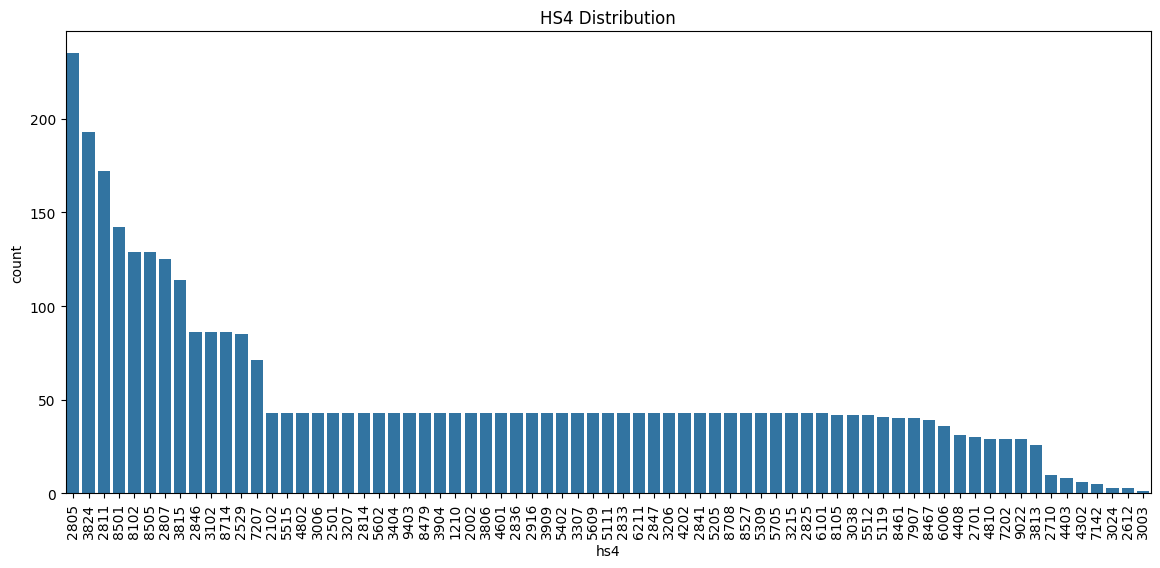

In [30]:
# HS4 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.countplot(data=df, x="hs4", order=df["hs4"].value_counts().index)
plt.xticks(rotation=90)
plt.title("HS4 Distribution")
plt.show()

**코드 셀 동작 설명**

- **주요 범주**: 시각화/플롯 생성, 시각화(Seaborn)
- 그래프/차트로 결과 시각화

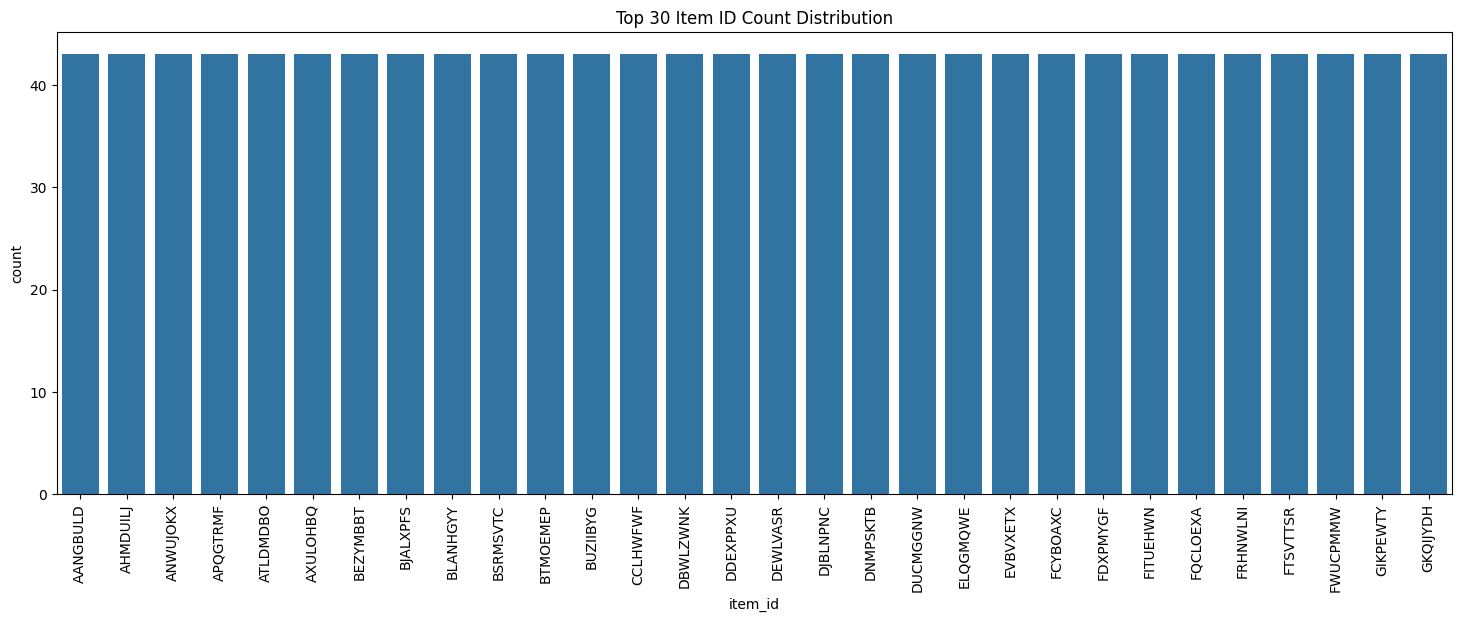

In [31]:
# item_id 분포 시각화

plt.figure(figsize=(18,6))
sns.countplot(data=df, x="item_id", order=df["item_id"].value_counts().index[:30])
plt.xticks(rotation=90)
plt.title("Top 30 Item ID Count Distribution")
plt.show()

## 3. item_id Micro-level Deep Dive

- item_id 5~10개 랜덤 추출
- 월별 value / weight / quantity 시계열 패턴 분석
- zero 패턴(0 비율) 분석
- 결측 패턴(NaN 비율) 분석
- 급증/급감(anomaly) 탐지
- HS 코드 cross-check (item_id에 여러 HS4가 존재하는지)
- 각 item_id별 상세 그래프 자동 생성(멀티 플롯)

**코드 셀 동작 설명**

- **주요 범주**: 라이브러리 임포트, 집계/그룹 연산, 수치/데이터프레임 처리
- 그룹 기준으로 집계/통계 계산

In [32]:
import numpy as np

# df_panel 기준 사용
df = df_panel.copy()

# 8개 랜덤 sample (재현성 위해 seed 고정)
np.random.seed(42)
sample_items = np.random.choice(df['item_id'].unique(), size=8, replace=False)
sample_df = df[df['item_id'].isin(sample_items)]

monthly_trend = (
    sample_df.groupby(['item_id', 'date'])
             [['value', 'weight', 'quantity']]
             .sum()
             .reset_index()
)

monthly_trend.head()

,item_id,date,value,weight,quantity
0,FDXPMYGF,2022-01-01,571.0,2.0,0.0
1,FDXPMYGF,2022-02-01,84.0,1.0,0.0
2,FDXPMYGF,2022-03-01,0.0,0.0,0.0
3,FDXPMYGF,2022-04-01,35.0,0.0,0.0
4,FDXPMYGF,2022-05-01,2712.0,706.0,0.0


**코드 셀 동작 설명**

- **주요 범주**: 시각화/플롯 생성
- 그래프/차트로 결과 시각화

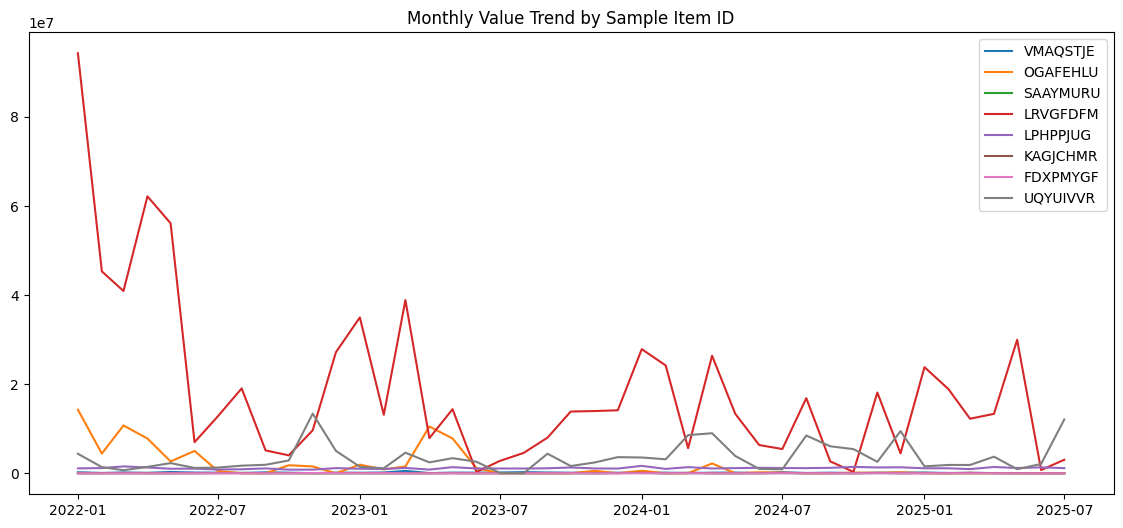

,item_id,date,value,weight,quantity


In [33]:
# 8개 item value 변화 시계열 그래프
plt.figure(figsize=(14,6))
for item in sample_items:
    tmp = monthly_trend[monthly_trend['item_id'] == item]
    plt.plot(tmp['date'], tmp['value'], label=item)

plt.title("Monthly Value Trend by Sample Item ID")
plt.legend()
plt.show()

monthly_trend[monthly_trend['item_id'] == 'GKQIJYDH']

**코드 셀 동작 설명**

- **주요 범주**: 중복 데이터 처리
- 중복 행을 탐지하여 제거

In [34]:
df.head()
df.duplicated().sum()

np.int64(0)

**코드 셀 동작 설명**

- **주요 범주**: 집계/그룹 연산
- 그룹 기준으로 집계/통계 계산

In [35]:
# Zero / Missing 패턴 분석
# 최소 수정: 필요한 flag 컬럼이 없으면 즉석 생성, sample_items 미정의 시 간단히 정의
if 'sample_items' not in globals():
    sample_items = df['item_id'].dropna().unique()[:8]

flag_sources = [
    ('value_zero', 'value'),
    ('weight_zero', 'weight'),
    ('quantity_zero', 'quantity'),
]
for flag, base in flag_sources:
    if flag not in df.columns and base in df.columns:
        df[flag] = (df[base] == 0).astype(int)

missing_sources = [
    ('value_missing', 'value'),
    ('weight_missing', 'weight'),
    ('quantity_missing', 'quantity'),
]
for flag, base in missing_sources:
    if flag not in df.columns and base in df.columns:
        df[flag] = df[base].isna().astype(int)

zero_missing_stats = (
    df[df['item_id'].isin(sample_items)]
    .groupby('item_id')[['value_zero', 'weight_zero', 'quantity_zero',
                         'value_missing', 'weight_missing', 'quantity_missing']]
    .mean(numeric_only=True)
    .reset_index()
)

zero_missing_stats

,item_id,value_zero,weight_zero,quantity_zero,value_missing,weight_missing,quantity_missing
0,FDXPMYGF,0.0,0.046512,0.930233,0.069767,0.069767,0.069767
1,KAGJCHMR,0.0,0.000000,0.000000,0.093023,0.093023,0.093023
2,LPHPPJUG,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
3,LRVGFDFM,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
4,OGAFEHLU,0.0,0.000000,0.674419,0.325581,0.325581,0.325581
5,SAAYMURU,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
6,UQYUIVVR,0.0,0.000000,0.000000,0.023256,0.023256,0.023256
7,VMAQSTJE,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


**코드 셀 동작 설명**

- **주요 범주**: 집계/그룹 연산, 정렬
- 그룹 기준으로 집계/통계 계산

In [36]:
#급증/급감 패턴(anomaly) 탐지
monthly_trend = monthly_trend.sort_values(['item_id', 'date'])

# 전월 대비 변화율
monthly_trend['value_pct_change'] = (
    monthly_trend.groupby('item_id')['value'].pct_change()
)

# 급증 top 5, 급감 bottom 5
top_spikes = monthly_trend.sort_values('value_pct_change', ascending=False).head(5)
bottom_spikes = monthly_trend.sort_values('value_pct_change', ascending=True).head(5)

top_spikes, bottom_spikes

(      item_id       date      value    weight  quantity  value_pct_change
 278  UQYUIVVR 2023-09-01  4396445.0  244559.0      20.0               inf
 17   FDXPMYGF 2023-06-01     6480.0      92.0       0.0               inf
 45   KAGJCHMR 2022-03-01    28015.0     102.0     115.0               inf
 47   KAGJCHMR 2022-05-01     1694.0       6.0       3.0               inf
 58   KAGJCHMR 2023-04-01     9341.0      85.0      11.0               inf,
       item_id       date  value  weight  quantity  value_pct_change
 2    FDXPMYGF 2022-03-01    0.0     0.0       0.0              -1.0
 44   KAGJCHMR 2022-02-01    0.0     0.0       0.0              -1.0
 56   KAGJCHMR 2023-02-01    0.0     0.0       0.0              -1.0
 46   KAGJCHMR 2022-04-01    0.0     0.0       0.0              -1.0
 277  UQYUIVVR 2023-08-01    0.0     0.0       0.0              -1.0)

**코드 셀 동작 설명**

- **주요 범주**: 집계/그룹 연산
- 그룹 기준으로 집계/통계 계산

In [37]:
# HS 코드 cross-check (item_id -> hs4 mapping consistency)
item_hs_check = (
    df.groupby('item_id')['hs4']
      .nunique()
      .reset_index(name='hs4_count')
)

# HS4가 여러 개 존재하는 item만 추출
item_hs_issue = item_hs_check[item_hs_check['hs4_count'] > 1]

item_hs_issue

,item_id,hs4_count


**코드 셀 동작 설명**

- **주요 범주**: 중복 데이터 처리
- 중복 행을 탐지하여 제거

In [38]:
df.duplicated().sum()

np.int64(0)

**코드 셀 동작 설명**

- **주요 범주**: 중복 데이터 처리, 행/열 선택 및 필터링
- 중복 행을 탐지하여 제거

In [39]:
(item_hs_check['hs4_count'] > 1).sum()
df[df['item_id'] == df['item_id'].iloc[0]][['item_id','hs4']].drop_duplicates()

,item_id,hs4
0,AANGBULD,4810
3,AANGBULD,<NA>


**코드 셀 동작 설명**

- **주요 범주**: 시각화/플롯 생성
- 그래프/차트로 결과 시각화

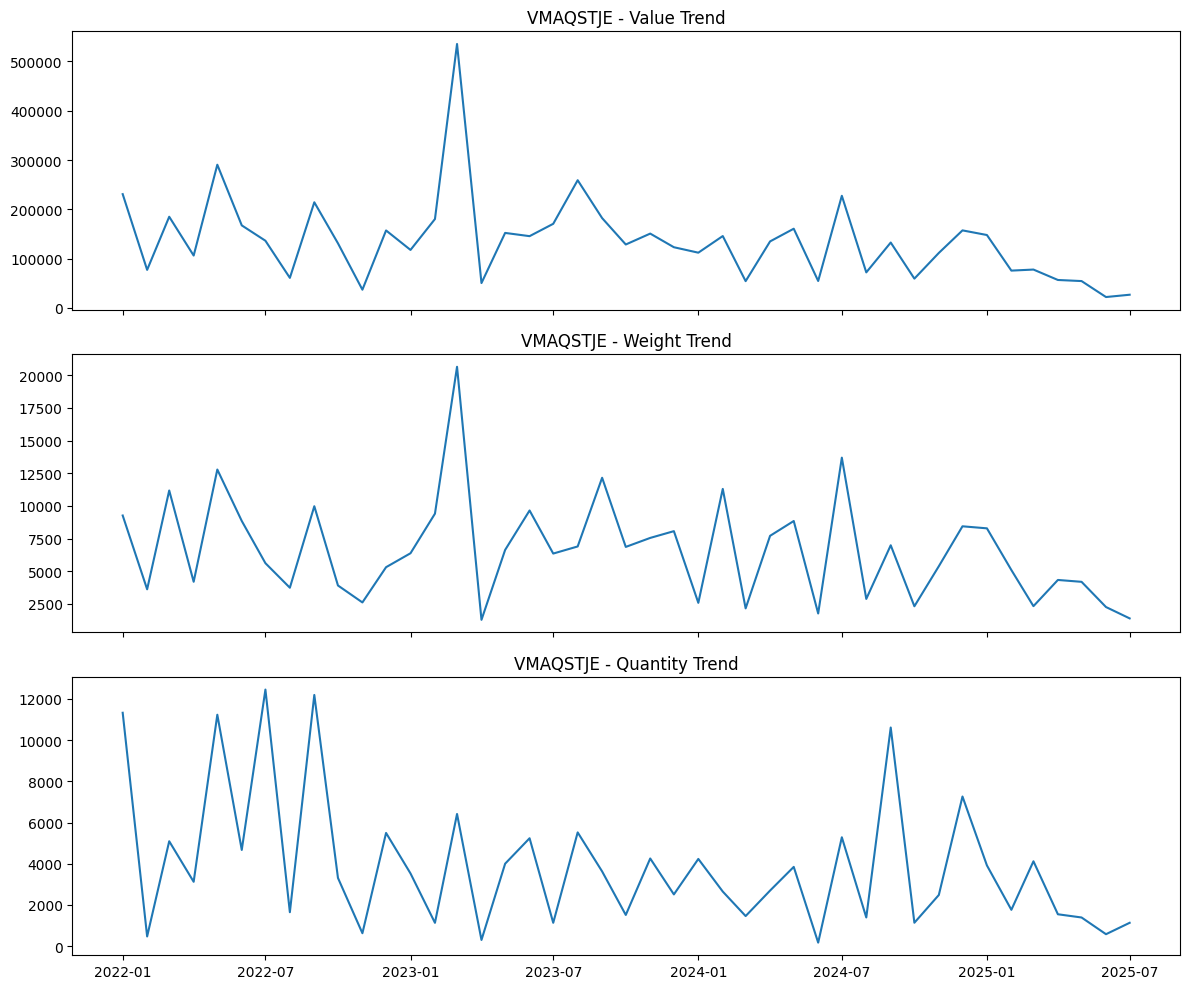

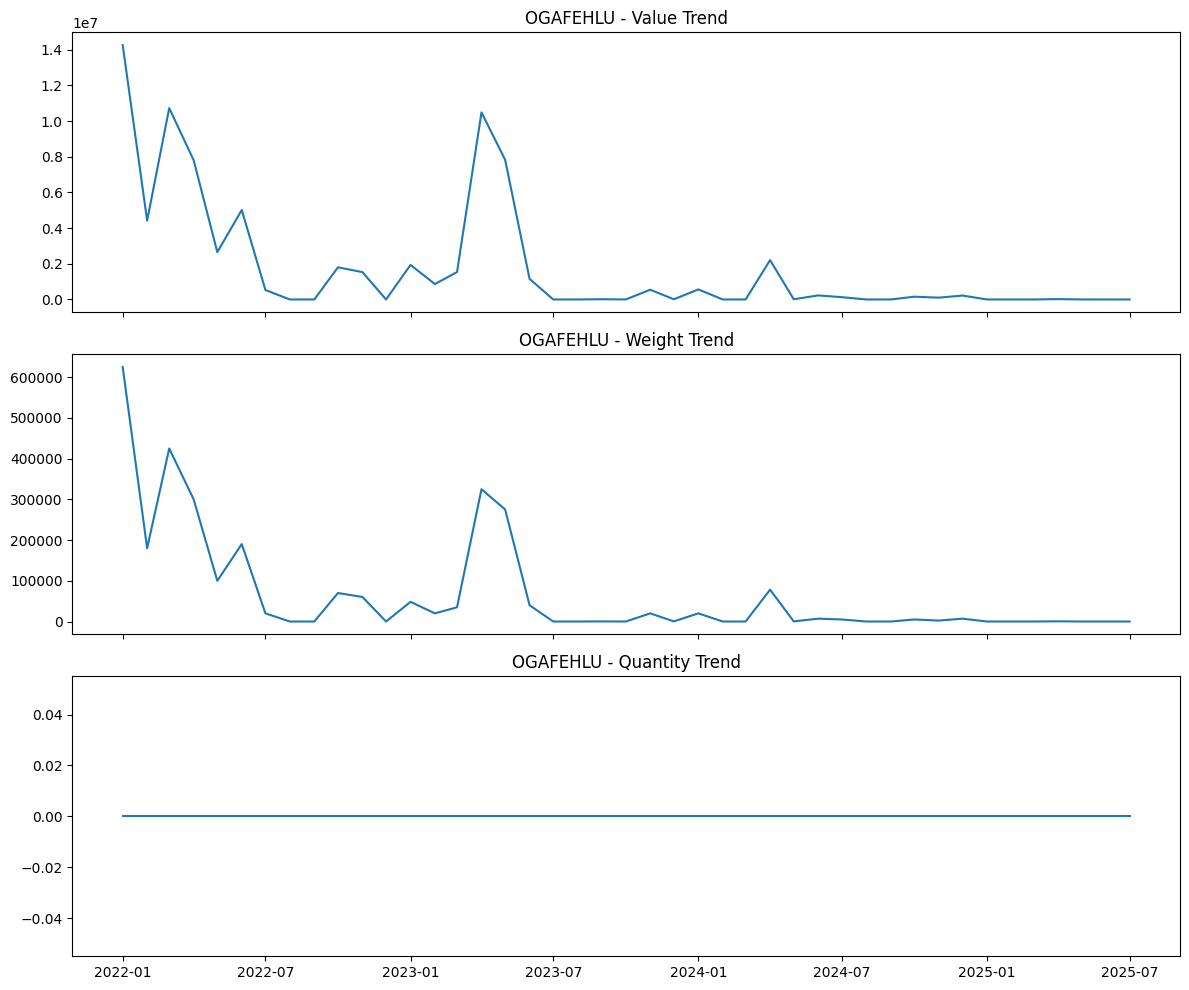

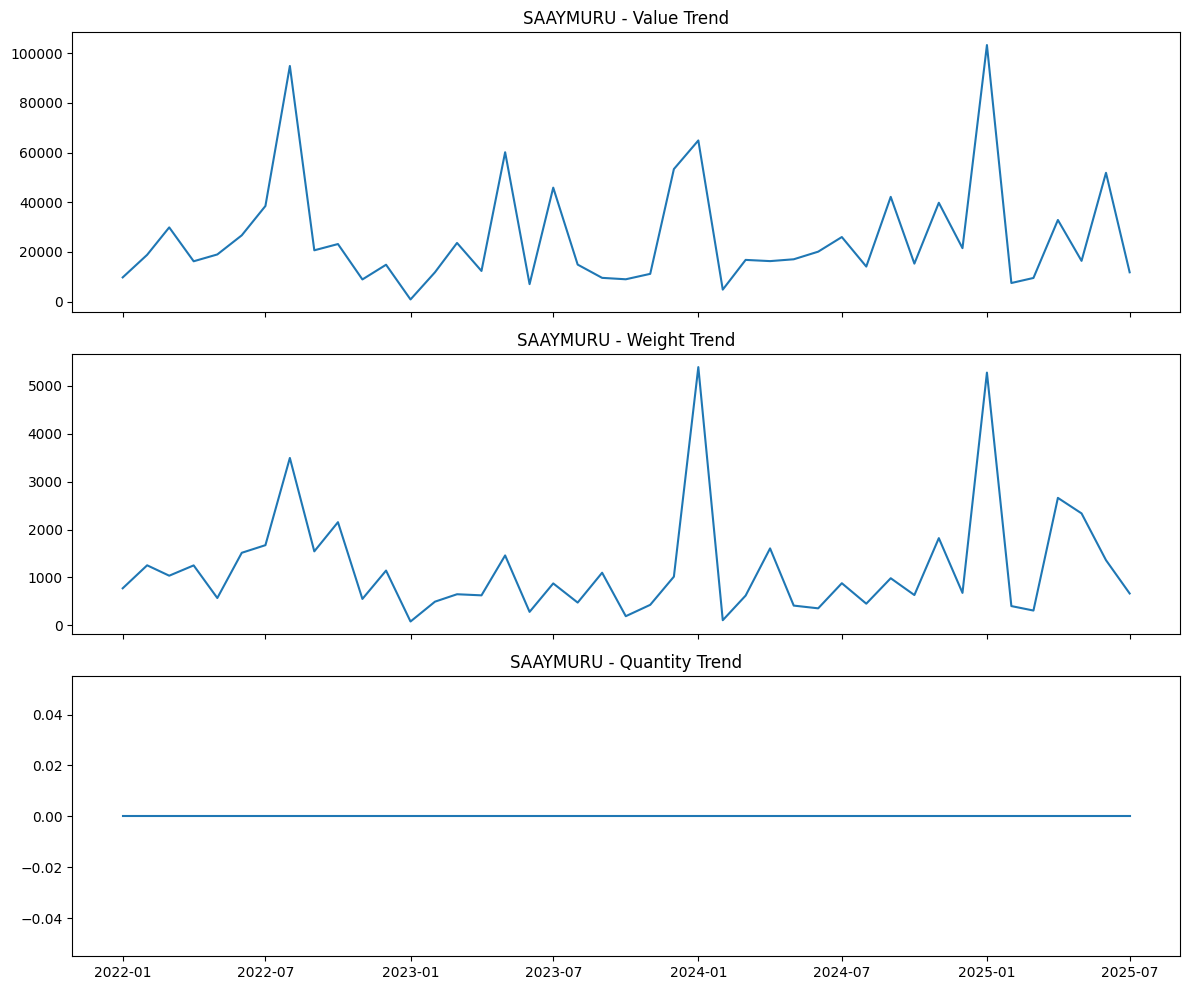

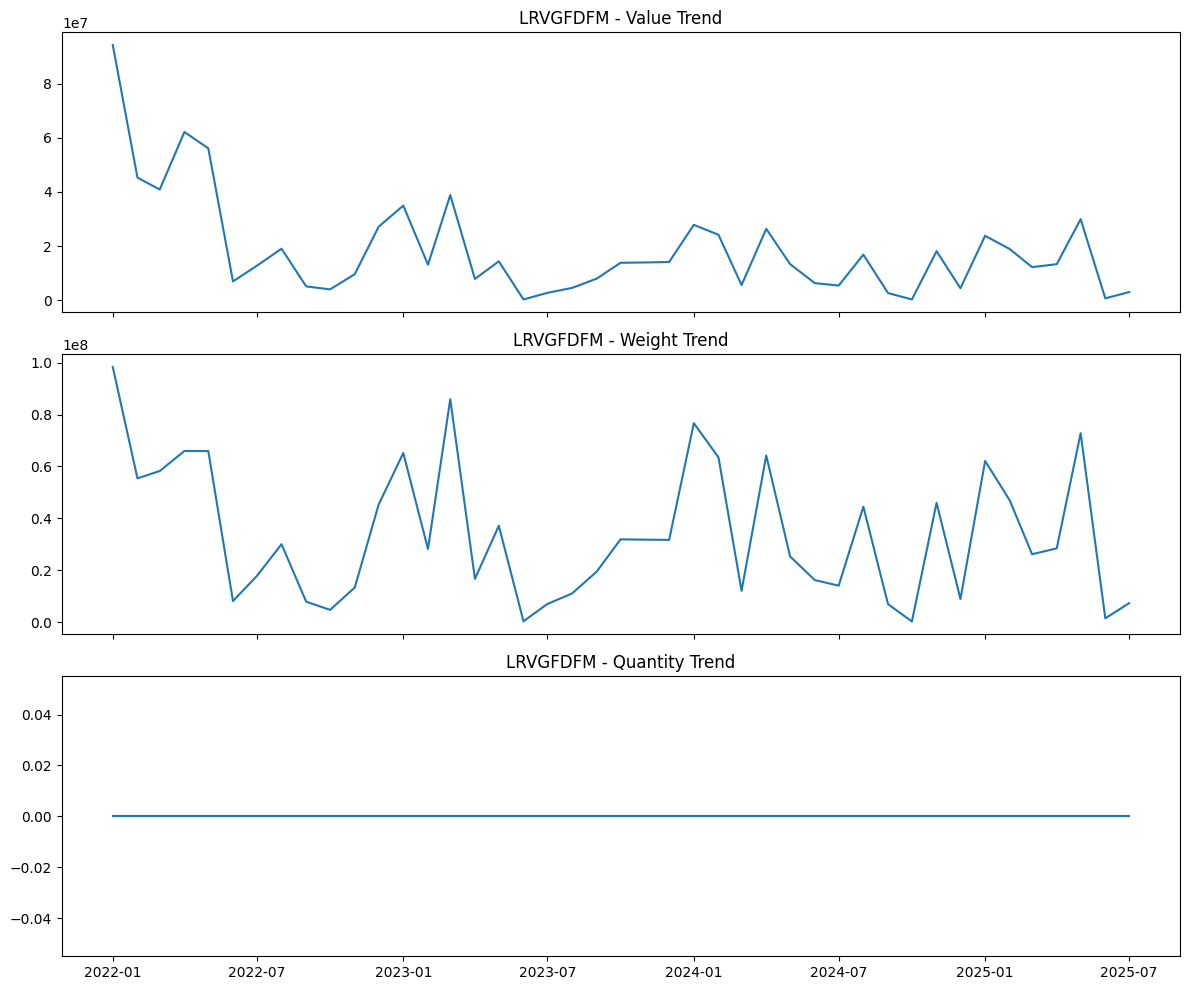

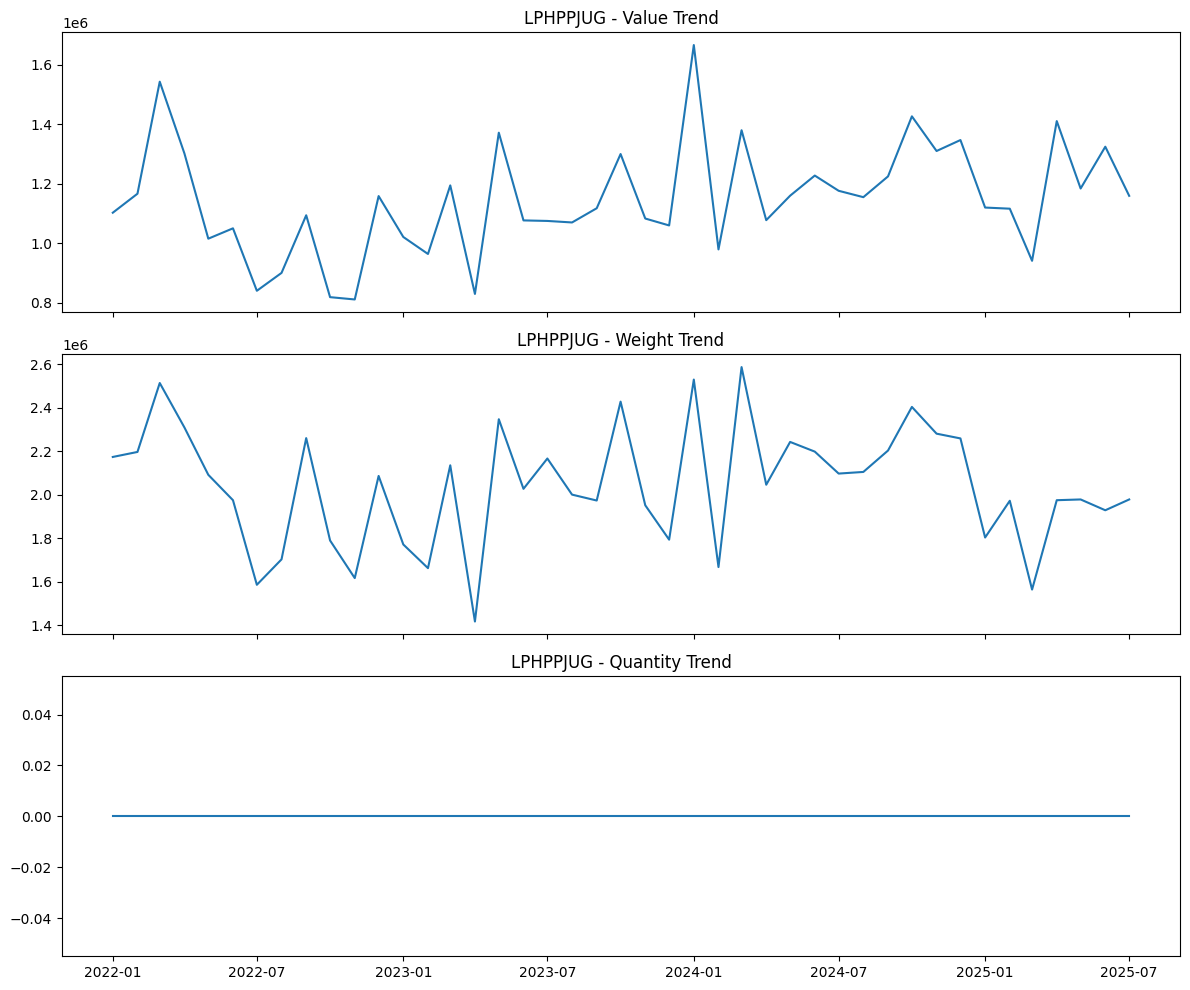

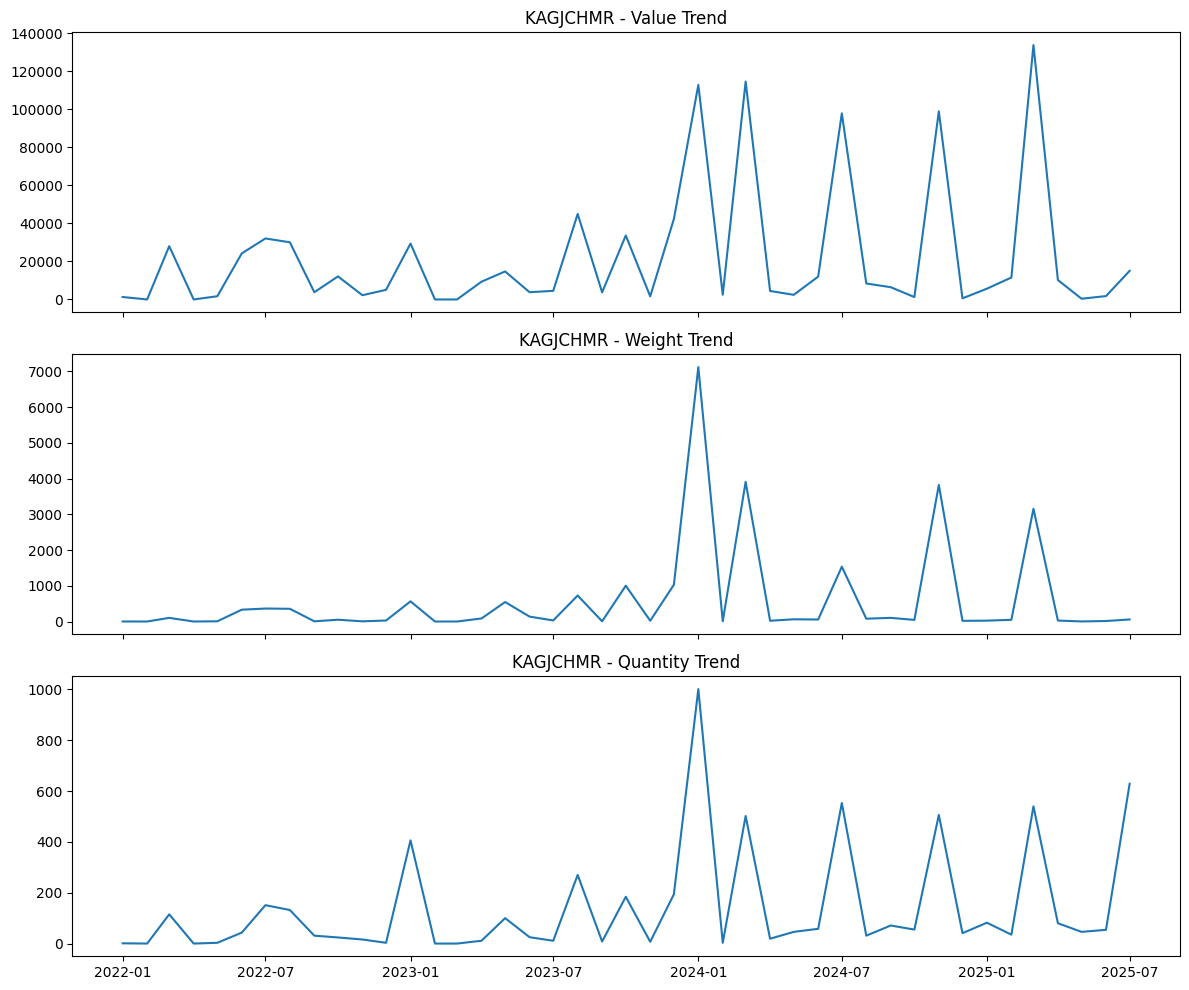

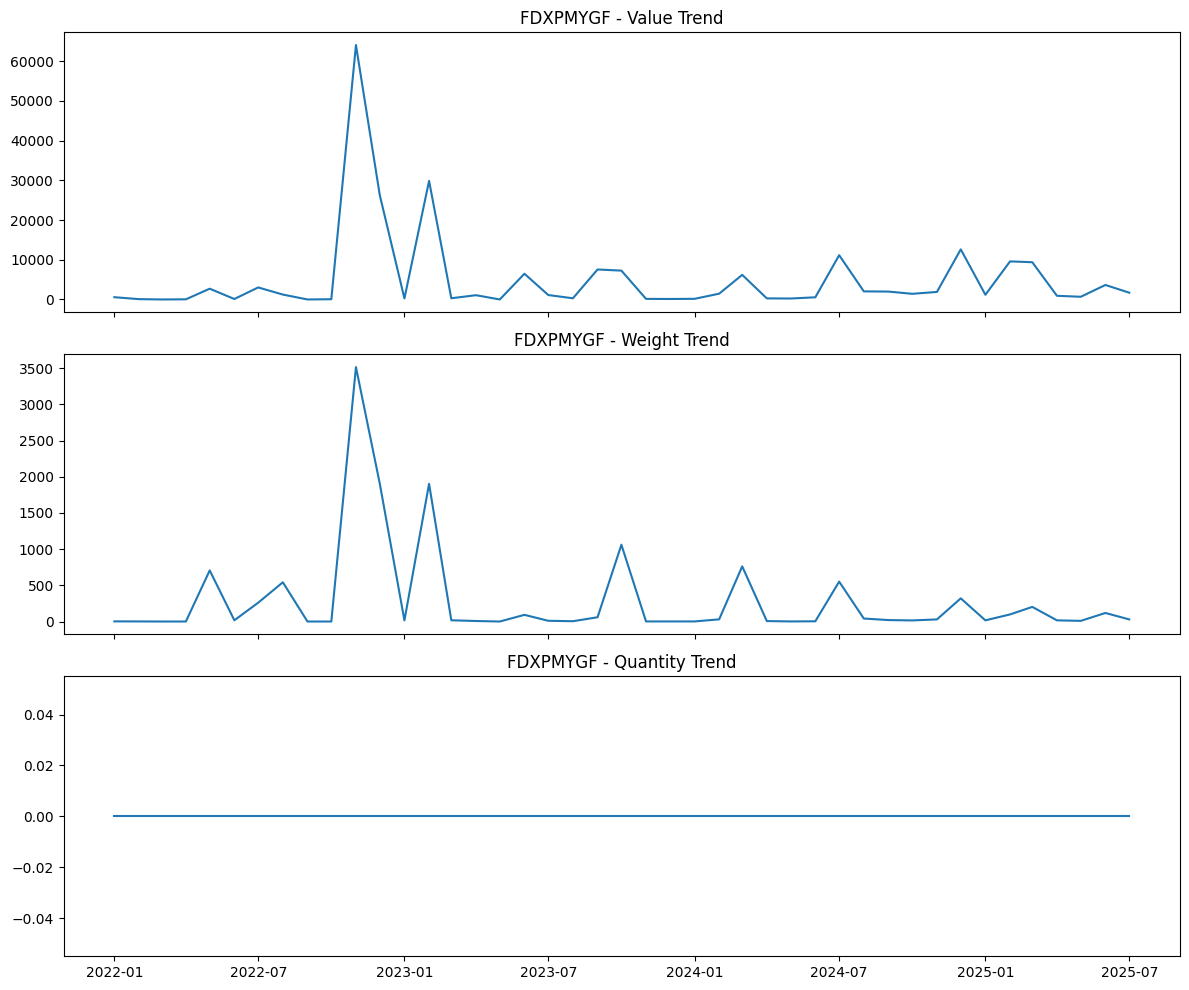

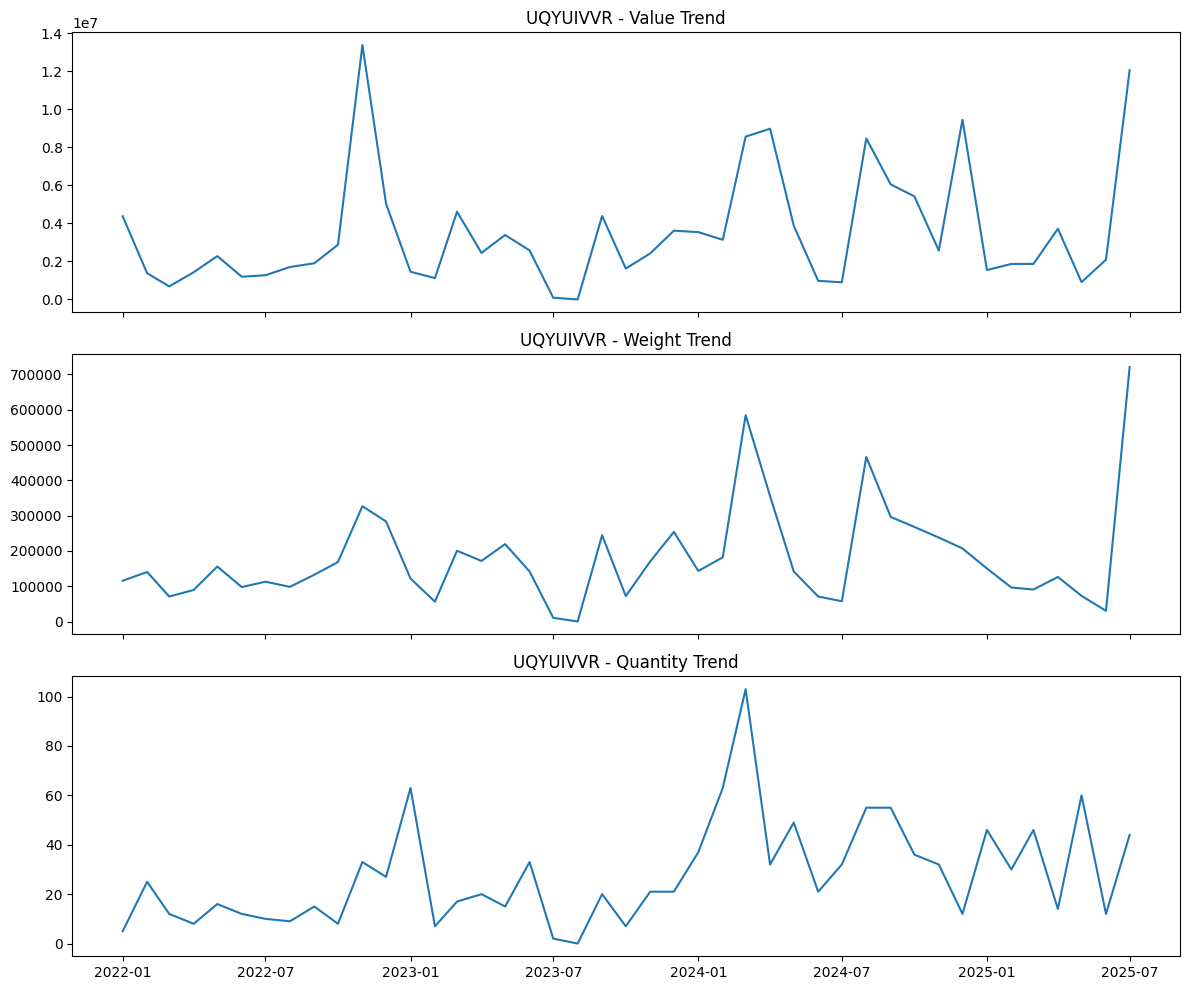

In [40]:
# 각 item_id별 상세 그래프 자동 생성 (value/weight/quantity)
for item in sample_items:
    tmp = monthly_trend[monthly_trend['item_id'] == item]

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(tmp['date'], tmp['value'])
    axes[0].set_title(f"{item} - Value Trend")

    axes[1].plot(tmp['date'], tmp['weight'])
    axes[1].set_title(f"{item} - Weight Trend")

    axes[2].plot(tmp['date'], tmp['quantity'])
    axes[2].set_title(f"{item} - Quantity Trend")

    plt.tight_layout()
    plt.show()

In [41]:
import pandas as pd

# 1) 결측 월/실제 0 거래 구분
value_cols = ['value', 'weight', 'quantity']

if 'is_missing_month' not in df_panel.columns:
    df_panel['is_missing_month'] = df_panel[value_cols].isna().all(axis=1)

summary_flags = []
for col in value_cols:
    zero_flag = f'{col}_zero'
    miss_flag = f'{col}_missing'
    if zero_flag not in df_panel.columns:
        df_panel[zero_flag] = (df_panel[col] == 0).astype(int)
    if miss_flag not in df_panel.columns:
        df_panel[miss_flag] = df_panel[col].isna().astype(int)
    summary_flags.extend([zero_flag, miss_flag])

# 2) 아이템 × 기간별 (연-월) 품질 요약
df_panel['year_month'] = df_panel['date'].dt.to_period('M')

quality_summary = (
    df_panel.groupby(['item_id', 'year_month'])
            .agg({
                'is_missing_month': 'mean',
                'value_zero': 'mean',
                'value_missing': 'mean',
                'weight_zero': 'mean',
                'weight_missing': 'mean',
                'quantity_zero': 'mean',
                'quantity_missing': 'mean'
            })
            .rename(columns=lambda c: f'{c}_ratio')
            .reset_index()
)

# 3) HS4 수준 품질 요약 (참고용)
hs4_quality = (
    df_panel.groupby('hs4')[summary_flags + ['is_missing_month']]
            .mean(numeric_only=True)
            .reset_index()
)

print("아이템-월 품질 요약 예시:")
print(quality_summary.head())

print("\nHS4 품질 요약 예시:")
print(hs4_quality.head())

아이템-월 품질 요약 예시:
    item_id year_month  is_missing_month_ratio  value_zero_ratio  \
0  AANGBULD    2022-01                     0.0               0.0   
1  AANGBULD    2022-02                     0.0               0.0   
2  AANGBULD    2022-03                     0.0               0.0   
3  AANGBULD    2022-04                     1.0               0.0   
4  AANGBULD    2022-05                     0.0               0.0   

   value_missing_ratio  weight_zero_ratio  weight_missing_ratio  \
0                  0.0                0.0                   0.0   
1                  0.0                0.0                   0.0   
2                  0.0                0.0                   0.0   
3                  1.0                0.0                   1.0   
4                  0.0                0.0                   0.0   

   quantity_zero_ratio  quantity_missing_ratio  
0                  1.0                     0.0  
1                  1.0                     0.0  
2                  1.0   